# Random walk

In [1]:
# Load generated data from file:
import pickle

from evaluation_icml2022 import *

experiments = {}
num_chains = 10
configs = [
    (L, alpha, K) for L in [5] for alpha in [1.0, 0.1] for K in [0, 1, 2]
]
for L, alpha, K in configs:
    key = toconfigstr(None, alpha, K)
    experiments[key] = []
    for i in range(num_chains):
        with open(f"lookahead_samples/walk_model_{i}__count1000_eps0.1_L{L}_alpha{alpha}_K{K}.pickle", "rb") as f:
            experiments[key].append(pickle.load(f))
with open(f"samples_produced/walk_is_10000000.pickle", "rb") as f:
    weighted_ground_truth, ground_truth = pickle.load(f)
    thinned_ground_truth = ground_truth[::10]

In [2]:
adjusted_experiments = adjust_for_iteration_time(experiments)

effort=defaultdict(<class 'list'>, {('npdhmc', ''): [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], ('npladhmc', 'K=1'): [5075, 5055, 5035, 5040, 5045, 5035, 5040, 5070, 5065, 5040], ('npladhmc', 'K=2'): [5110, 5060, 5090, 5130, 5110, 5050, 5080, 5120, 5090, 5110], ('npdhmc-persistent', 'α=0.1'): [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], ('npladhmc-persistent', 'α=0.1, K=1'): [5120, 5065, 5080, 5040, 5045, 5130, 5080, 5060, 5100, 5105], ('npladhmc-persistent', 'α=0.1, K=2'): [5185, 5130, 5140, 5110, 5125, 5205, 5165, 5090, 5140, 5180]})
reduction_factor={('npdhmc', ''): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], ('npladhmc', 'K=1'): [1.015, 1.011, 1.007, 1.008, 1.009, 1.007, 1.008, 1.014, 1.013, 1.008], ('npladhmc', 'K=2'): [1.022, 1.012, 1.018, 1.026, 1.022, 1.01, 1.016, 1.024, 1.018, 1.022], ('npdhmc-persistent', 'α=0.1'): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], ('npladhmc-persistent', 'α=0.1, K=1'): [1.024, 1.013, 1.016, 1.008, 

In [3]:
values = {}
chains = {}
for config, runs in adjusted_experiments.items():
    print(f"{config}")
    thinned_runs = thin_runs(runs, burnin=0)
    chains.update(collect_chains(thinned_runs, config=config))
    values.update(collect_values(thinned_runs, config=config))
    print_running_time(runs, thinned_runs)


npdhmc: 279.14s    0.0279s per sample (after thinning)
K=1
npladhmc: 278.46s    0.0281s per sample (after thinning)
K=2
npladhmc: 281.46s    0.0287s per sample (after thinning)
α=0.1
npdhmc-persistent: 195.01s    0.0195s per sample (after thinning)
α=0.1, K=1
npladhmc-persistent: 205.83s    0.0209s per sample (after thinning)
α=0.1, K=2
npladhmc-persistent: 201.95s    0.0208s per sample (after thinning)


In [4]:
import torch

print("Acceptance ratios (lookahead statistics in parentheses):")
for config, runs in experiments.items():
    for method in runs[0].keys():
        stats = sum(torch.tensor(run[method]["stats"]) for run in runs)
        ratios = (stats.true_divide(torch.sum(stats))).tolist()
        accept_ratio = 1.0 - ratios[0]
        ratios_str = ", ".join(f"{r*100:.1f}%" for r in ratios[1:])
        print(f"{legend_str((method, config))}: {accept_ratio * 100:.1f}% ({ratios_str})")

Acceptance ratios (lookahead statistics in parentheses):
NP-DHMC: 99.2% (99.2%)
NP-Lookahead-DHMC (K=1): 99.1% (99.0%, 0.1%)
NP-Lookahead-DHMC (K=2): 99.1% (99.0%, 0.0%, 0.0%)
NP-DHMC pers. (α=0.1): 98.6% (98.6%)
NP-Lookahead-DHMC pers. (α=0.1, K=1): 98.4% (98.4%, 0.1%)
NP-Lookahead-DHMC pers. (α=0.1, K=2): 98.7% (98.5%, 0.1%, 0.1%)


In [5]:
import numpyro.diagnostics as diag
import torch
import math

def ess_is(log_weights: list) -> float:
    log_weights = torch.tensor(log_weights)
    log_sum_of_squared = torch.logsumexp(2 * log_weights, dim=0)
    log_square_of_sum = 2 * torch.logsumexp(log_weights, dim=0)
    log_ess = log_square_of_sum - log_sum_of_squared
    return math.exp(log_ess.item())


print("Estimated effective sample sizes:")
for method in chains.keys():
    min_size = min(len(chain) for chain in chains[method])
    trimmed_chains = [chain[:min_size] for chain in chains[method]]
    numpy = torch.tensor(trimmed_chains).numpy()
    print(f"{legend_str(method)}:  {diag.effective_sample_size(numpy):.1f}")
# gt_log_weights = [w for (w, _) in weighted_ground_truth]
# print(f"ground:  {ess_is(gt_log_weights):.1f} (by weights)")

Estimated effective sample sizes:
NP-DHMC:  962.0
NP-Lookahead-DHMC (K=1):  962.0
NP-Lookahead-DHMC (K=2):  899.1
NP-DHMC pers. (α=0.1):  2791.6
NP-Lookahead-DHMC pers. (α=0.1, K=1):  3334.3
NP-Lookahead-DHMC pers. (α=0.1, K=2):  3244.1


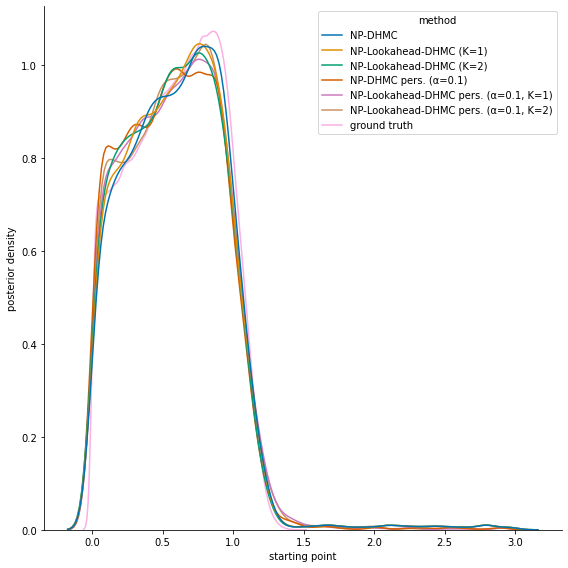

In [6]:
# Plot the Anglican data
import pandas
import torch
import matplotlib.pyplot as plt
import seaborn as sns

data = []
for method in values.keys():
    data += [(legend_str(method), v) for v in values[method]]
data += [("ground truth", v) for v in thinned_ground_truth]
x_label = "starting point"
dataframe = pandas.DataFrame(data, columns=["method", x_label])
plot = sns.displot(
    data=dataframe,
    x=x_label,
    hue="method",
    kind="kde",
    common_norm=False,
    facet_kws={"legend_out": False},
    aspect=1,
    height=8,
)
plot.set_ylabels(label="posterior density")
plot.savefig("icml2022-walk-kde.pdf", bbox_inches="tight")

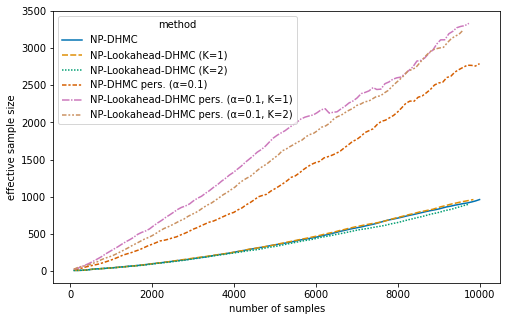

In [7]:
# graph effective sample size:
import pandas
from tqdm import tqdm

ess_data = []
for method in chains.keys():
    min_size = min(len(chain) for chain in chains[method])
    trimmed_chains = [chain[:min_size] for chain in chains[method]]
    np_chains = torch.tensor(trimmed_chains).numpy()
    num_chains, num_samples = np_chains.shape
    for i in range(1, 101):
        n = i * num_samples // 100
        ess = diag.effective_sample_size(np_chains[:, :n]).item()
        ess_data.append((legend_str(method), n * num_chains, ess))
df = pandas.DataFrame(ess_data, columns=["method", "number of samples", "effective sample size"])
plt.figure(figsize=(8,5))
plot = sns.lineplot(
    data=df,
    x="number of samples",
    y="effective sample size",
    hue="method",
    style="method",
)
plot.get_figure().savefig("icml2022-walk-ess-plot.pdf", bbox_inches="tight")